# Efficient Frontier

The following code calculates an Efficient Frontier for up to six assets. The user can choose which assets they would like to incorporate into their portfolio. Options include: S&P 500, Fixed Income, Gold, Private Credit, Real Estate, and Private Equity. The user can also select the time frame of the historical data used in the calculation.

In [26]:
import cvxpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
dropped_assets_string = input("Input the assets you would like to drop.\nMake sure to spell the assets correctly and separate each with a comma and a space.\nIf you do not want to drop any assets, simply press enter: ")

In [28]:
dropped_assets = dropped_assets_string.split(", ")
dropped_assets

['']

In [29]:
time_frame = input("Choose your desired time frame in years (1-10): ")

In [30]:
#Read in Data
asset_data = pd.read_csv("EF_Data_Summary.csv")
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
0,1/30/15,1994.99,1955.02,1283.79,933.11,317.41,1744.85
1,2/27/15,2104.50,1936.64,1213.18,987.22,308.89,1903.96
2,3/31/15,2067.89,1945.63,1183.57,979.69,310.75,1854.04
3,4/30/15,2085.51,1938.65,1184.37,989.70,295.33,1890.64
4,5/29/15,2107.39,1933.98,1190.58,989.64,293.95,1925.25
...,...,...,...,...,...,...,...
115,8/30/24,5648.40,2228.33,2503.39,1466.30,380.90,5001.46
116,9/30/24,5762.48,2258.17,2634.58,1468.34,391.07,5150.10
117,10/31/24,5705.45,2202.17,2743.97,1457.96,376.82,5038.92
118,11/29/24,6032.38,2225.45,2643.15,1504.10,391.66,5458.17


In [31]:
#drop rows of assets user does not want
if dropped_assets_string:
    asset_data = asset_data.drop(dropped_assets, axis=1)
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
0,1/30/15,1994.99,1955.02,1283.79,933.11,317.41,1744.85
1,2/27/15,2104.50,1936.64,1213.18,987.22,308.89,1903.96
2,3/31/15,2067.89,1945.63,1183.57,979.69,310.75,1854.04
3,4/30/15,2085.51,1938.65,1184.37,989.70,295.33,1890.64
4,5/29/15,2107.39,1933.98,1190.58,989.64,293.95,1925.25
...,...,...,...,...,...,...,...
115,8/30/24,5648.40,2228.33,2503.39,1466.30,380.90,5001.46
116,9/30/24,5762.48,2258.17,2634.58,1468.34,391.07,5150.10
117,10/31/24,5705.45,2202.17,2743.97,1457.96,376.82,5038.92
118,11/29/24,6032.38,2225.45,2643.15,1504.10,391.66,5458.17


In [32]:
#Create variable used to filter to desired time frame
included_rows = int(time_frame)*12
included_rows

120

In [33]:
#Filter to the desired time frame
asset_data = asset_data.tail(included_rows)
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
0,1/30/15,1994.99,1955.02,1283.79,933.11,317.41,1744.85
1,2/27/15,2104.50,1936.64,1213.18,987.22,308.89,1903.96
2,3/31/15,2067.89,1945.63,1183.57,979.69,310.75,1854.04
3,4/30/15,2085.51,1938.65,1184.37,989.70,295.33,1890.64
4,5/29/15,2107.39,1933.98,1190.58,989.64,293.95,1925.25
...,...,...,...,...,...,...,...
115,8/30/24,5648.40,2228.33,2503.39,1466.30,380.90,5001.46
116,9/30/24,5762.48,2258.17,2634.58,1468.34,391.07,5150.10
117,10/31/24,5705.45,2202.17,2743.97,1457.96,376.82,5038.92
118,11/29/24,6032.38,2225.45,2643.15,1504.10,391.66,5458.17


In [34]:
#Convert users' selected assets into a list for later use
selected_assets = asset_data.columns.tolist()
#take out Month
selected_assets = [col for col in selected_assets if col != 'Month']
# add "Weight" for later use
selected_assets = [col + ' Weight' for col in selected_assets]
selected_assets

['S&P 500 Weight',
 'Fixed Income Weight',
 'Gold Weight',
 'Private Credit Weight',
 'Real Estate Weight',
 'Private Equity Weight']

In [35]:
#Add "monthly return" to all columns besides Month
asset_data.columns = [col + " Monthly Return" if col != "Month" else col for col in asset_data.columns]

# Make every value a pct change except for the 'Month' column
asset_data.loc[:, asset_data.columns != "Month"] = asset_data.loc[:, asset_data.columns != "Month"].pct_change()
asset_data

,Month,S&P 500 Monthly Return,Fixed Income Monthly Return,Gold Monthly Return,Private Credit Monthly Return,Real Estate Monthly Return,Private Equity Monthly Return
0,1/30/15,NaN,NaN,NaN,NaN,NaN,NaN
1,2/27/15,0.054893,-0.009401,-0.055001,0.057989,-0.026842,0.091188
2,3/31/15,-0.017396,0.004642,-0.024407,-0.007627,0.006022,-0.026219
3,4/30/15,0.008521,-0.003588,0.000676,0.010218,-0.049622,0.019741
4,5/29/15,0.010491,-0.002409,0.005243,-0.000061,-0.004673,0.018306
...,...,...,...,...,...,...,...
115,8/30/24,0.022835,0.014367,0.022794,-0.016757,0.053403,0.029783
116,9/30/24,0.020197,0.013391,0.052405,0.001391,0.026700,0.029719
117,10/31/24,-0.009897,-0.024799,0.041521,-0.007069,-0.036438,-0.021588
118,11/29/24,0.057301,0.010571,-0.036742,0.031647,0.039382,0.083202


In [36]:
#Remove unwanted data and drop first row
asset_data_returns = asset_data.loc[:, asset_data.columns.str.contains("Return")]
asset_data_returns = asset_data_returns.dropna()
asset_data_returns                                                         

,S&P 500 Monthly Return,Fixed Income Monthly Return,Gold Monthly Return,Private Credit Monthly Return,Real Estate Monthly Return,Private Equity Monthly Return
1,0.054893,-0.009401,-0.055001,0.057989,-0.026842,0.091188
2,-0.017396,0.004642,-0.024407,-0.007627,0.006022,-0.026219
3,0.008521,-0.003588,0.000676,0.010218,-0.049622,0.019741
4,0.010491,-0.002409,0.005243,-0.000061,-0.004673,0.018306
5,-0.021012,-0.010905,-0.015312,-0.038175,-0.048274,-0.029601
...,...,...,...,...,...,...
115,0.022835,0.014367,0.022794,-0.016757,0.053403,0.029783
116,0.020197,0.013391,0.052405,0.001391,0.026700,0.029719
117,-0.009897,-0.024799,0.041521,-0.007069,-0.036438,-0.021588
118,0.057301,0.010571,-0.036742,0.031647,0.039382,0.083202


In [37]:
#Calculate Avg Monthly Returns and Annualize it
expected_returns = asset_data_returns.mean()
expected_returns = (1 + expected_returns)**12 - 1
expected_returns

S&P 500 Monthly Return           0.128229
Fixed Income Monthly Return      0.012725
Gold Monthly Return              0.084758
Private Credit Monthly Return    0.067673
Real Estate Monthly Return       0.028228
Private Equity Monthly Return    0.152908
dtype: float64

In [38]:
#Calculate Covariance Matrix and Annualize it
cov_matrix = asset_data_returns.cov() * 12
cov_matrix

,S&P 500 Monthly Return,Fixed Income Monthly Return,Gold Monthly Return,Private Credit Monthly Return,Real Estate Monthly Return,Private Equity Monthly Return
S&P 500 Monthly Return,0.023562,0.002991,0.002239,0.021757,0.021738,0.038284
Fixed Income Monthly Return,0.002991,0.002512,0.002947,0.002028,0.005153,0.004653
Gold Monthly Return,0.002239,0.002947,0.019038,-0.000292,0.004884,0.002986
Private Credit Monthly Return,0.021757,0.002028,-0.000292,0.034602,0.023044,0.034859
Real Estate Monthly Return,0.021738,0.005153,0.004884,0.023044,0.031581,0.034552
Private Equity Monthly Return,0.038284,0.004653,0.002986,0.034859,0.034552,0.067800


In [39]:
#Primary Calculations
n = len(cov_matrix)
weights = cp.Variable(n)
weights

Variable((6,), var412)

In [40]:
#Calculate Target Returns
target_returns = np.linspace(
expected_returns.min(),
expected_returns.max(),
10 # Number of points on the frontier
)
target_returns

array([0.0127249 , 0.02830082, 0.04387673, 0.05945265, 0.07502856,
       0.09060448, 0.10618039, 0.12175631, 0.13733222, 0.15290813])

In [41]:
# Store results
efficient_portfolios = []
for target_return in target_returns:
    # Objective: Minimize portfolio variance
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(portfolio_variance)
    # Constraints
    constraints = [
        weights >= 0, # No short-selling
        cp.sum(weights) == 1, # Fully invested
        expected_returns.values @ weights >= target_return # Target return
        ]
    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
    if prob.status == 'optimal':
        annualized_return = expected_returns.values @ weights.value
        annualized_variance = portfolio_variance.value
        efficient_portfolios.append({
            'Weights': weights.value,
            'Return': annualized_return,
            'Variance': annualized_variance
            })

In [42]:
# Convert to DataFrame
efficient_frontier = pd.DataFrame(efficient_portfolios)
efficient_frontier['Standard Deviation'] = np.sqrt(efficient_frontier['Variance'])
# Remove duplicates (if any)
efficient_frontier = efficient_frontier.drop_duplicates(['Return', 'Variance'])
efficient_frontier

,Weights,Return,Variance,Standard Deviation
0,"[7.622423819035679e-23, 0.9853653607063354, -5...",0.013529,0.002505,0.050048
1,"[0.0920183892888027, 0.8392986858438818, 0.068...",0.028301,0.002889,0.053748
2,"[0.18063465351067007, 0.6765442019399703, 0.14...",0.043877,0.003723,0.061017
3,"[0.26925091773253745, 0.513789718036059, 0.216...",0.059453,0.005014,0.070807
4,"[0.35786718195440487, 0.35103523413214743, 0.2...",0.075029,0.006761,0.082223
5,"[0.44648344617627217, 0.18828075022823618, 0.3...",0.090604,0.008964,0.094679
6,"[0.5350997103981397, 0.025526266324324618, 0.4...",0.106180,0.011624,0.107815
7,"[0.8511046546939148, -4.814917387727073e-23, 0...",0.121756,0.018058,0.134378
8,"[0.6311369946681797, 2.5538046400031457e-22, 1...",0.137332,0.036436,0.190882
9,"[-6.1142038313775446e-09, 9.228922679934483e-1...",0.152908,0.067800,0.260384


In [43]:
# Split the 'Weights' into independent columns
efficient_frontier[selected_assets] = pd.DataFrame(efficient_frontier['Weights'].tolist(), index=efficient_frontier.index)

# Convert weights to percentages
efficient_frontier = efficient_frontier * 100

# Add '%' to the asset column names
efficient_frontier.columns = [f"{col} (%)" if 'Weight' in col else col for col in efficient_frontier.columns]

# Round the values to 2 decimal places
efficient_frontier = efficient_frontier.round(2)

# Change the index to 'Portfolio X' format
efficient_frontier.index = [f"Portfolio {i+1}" for i in range(len(efficient_frontier))]

# Rename columns
efficient_frontier = efficient_frontier.rename(columns={'Return': 'Expected Return (%)', 
                                                       'Variance': 'Variance (%)', 
                                                       'Standard Deviation': 'Standard Deviation (%)'})
#Drop Weights columns
efficient_frontier = efficient_frontier.drop("Weights (%)", axis=1)

#Drop Var Column
efficient_frontier = efficient_frontier.drop("Variance (%)", axis=1)
efficient_frontier

,Expected Return (%),Standard Deviation (%),S&P 500 Weight (%),Fixed Income Weight (%),Gold Weight (%),Private Credit Weight (%),Real Estate Weight (%),Private Equity Weight (%)
Portfolio 1,1.35,5.00,0.00,98.54,-0.00,1.46,0.0,0.00
Portfolio 2,2.83,5.37,9.20,83.93,6.87,-0.00,-0.0,-0.00
Portfolio 3,4.39,6.10,18.06,67.65,14.28,-0.00,-0.0,-0.00
Portfolio 4,5.95,7.08,26.93,51.38,21.70,-0.00,-0.0,-0.00
Portfolio 5,7.50,8.22,35.79,35.10,29.11,-0.00,-0.0,-0.00
Portfolio 6,9.06,9.47,44.65,18.83,36.52,0.00,0.0,0.00
Portfolio 7,10.62,10.78,53.51,2.55,43.94,0.00,0.0,0.00
Portfolio 8,12.18,13.44,85.11,-0.00,14.89,-0.00,-0.0,0.00
Portfolio 9,13.73,19.09,63.11,0.00,0.00,0.00,0.0,36.89
Portfolio 10,15.29,26.04,-0.00,0.00,-0.00,0.00,0.0,100.00


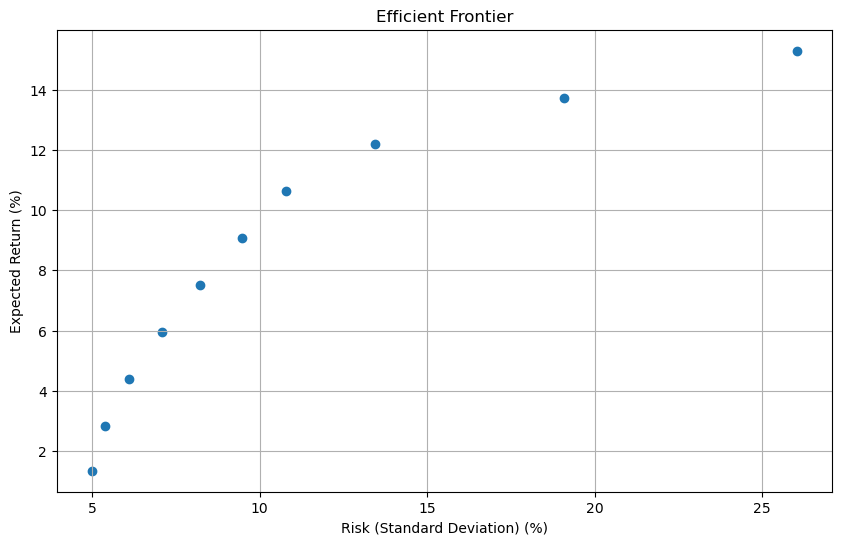

In [44]:
#Graph
plt.figure(figsize=(10, 6))
plt.scatter(
    efficient_frontier['Standard Deviation (%)'],
    efficient_frontier['Expected Return (%)'],
    marker='o'
)
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation) (%)')
plt.ylabel('Expected Return (%)')
plt.grid(True)
plt.show()